In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

In [2]:
inputFile = 'highdensity.csv'
repetitionsCount = -1 # -1 = auto-detect

tIntervalAlpha = 0.9

# Plots
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum']

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', 1000)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str) and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values(['X', 'Y', 'R', 'repetition'], inplace=True)
for index, row in scalars_wide.iterrows():
    if row['X'] == 0 and row['Y'] == 0:
        pos = 'corner'
    elif row['X'] == 0 or row['Y'] == 0:
        pos = 'border'
    else:
        pos = 'center'
    scalars_wide.loc[index, 'position'] = pos
scalars_wide = scalars_wide[['position', 'R', 'repetition', *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

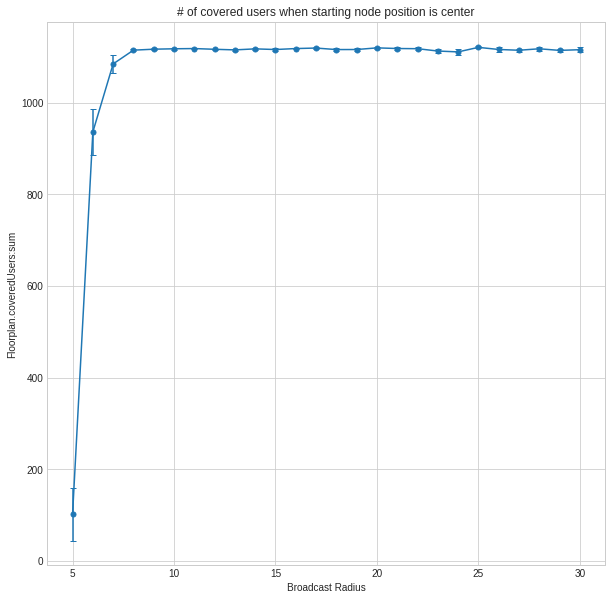

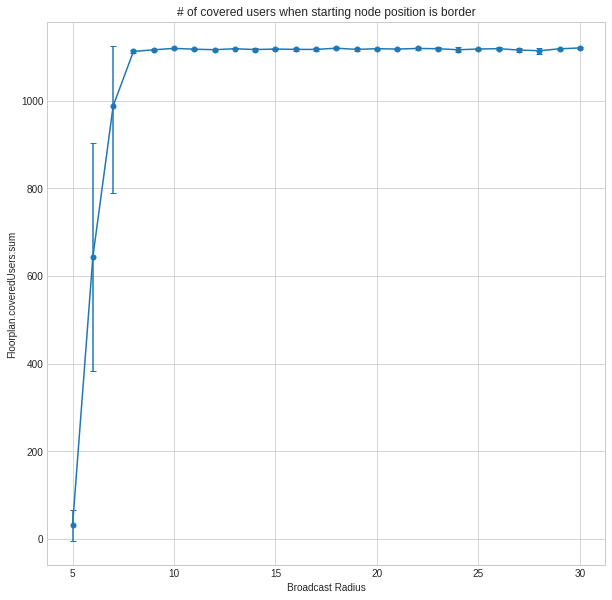

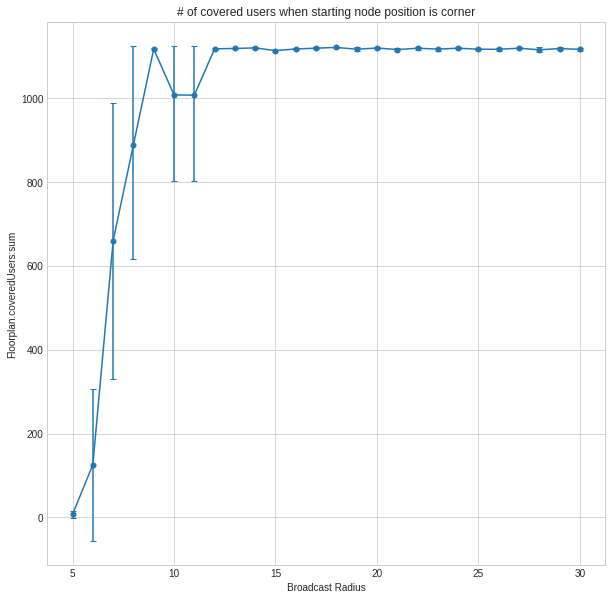

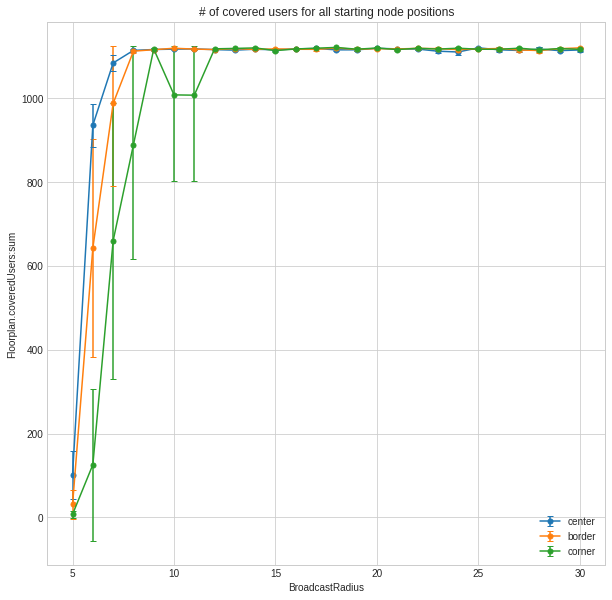

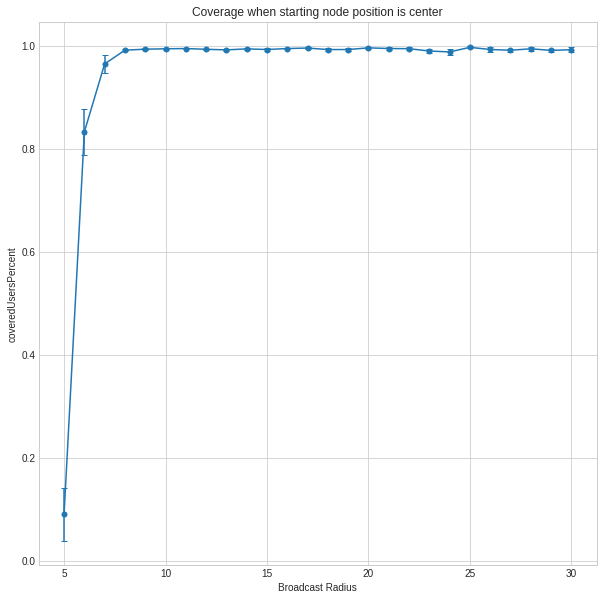

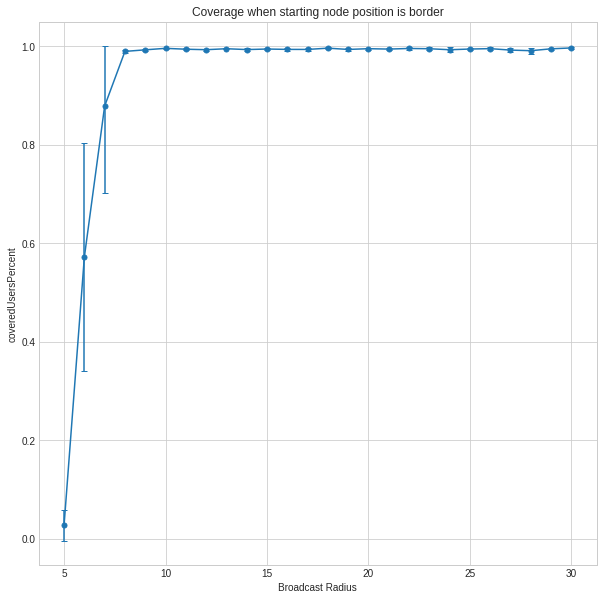

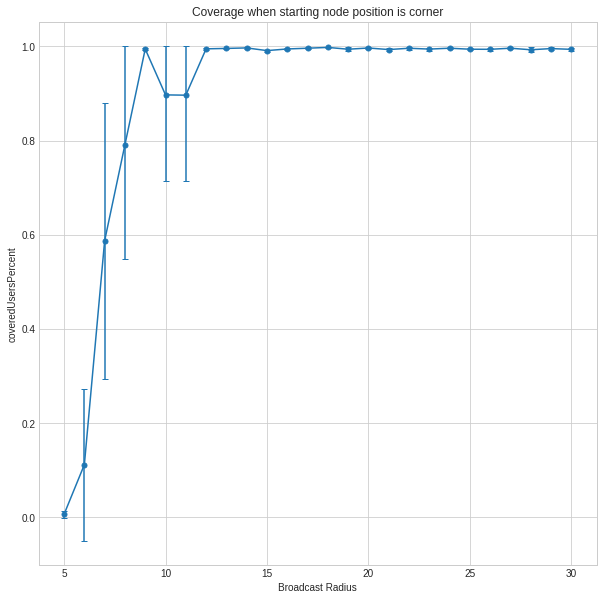

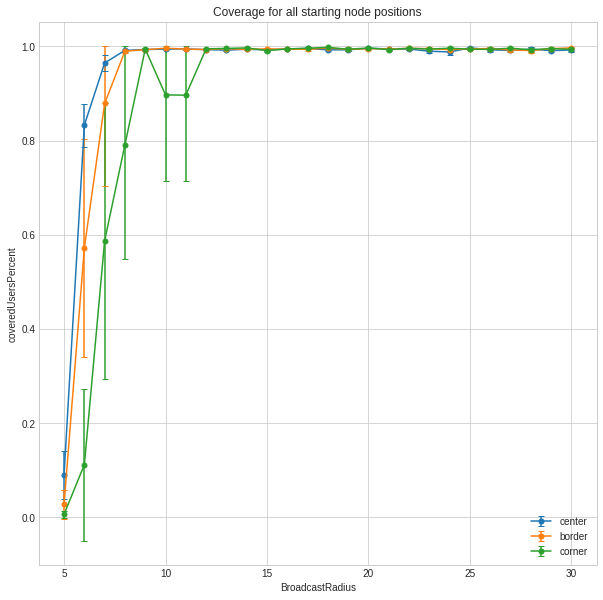

In [6]:
for col in ['Floorplan.coveredUsers:sum', 'coveredUsersPercent']:
    saved = {}
    for pos in ['center', 'border', 'corner']:
        current = scalars_wide[scalars_wide['position'] == pos]
        x = []
        y = []
        err = []
        poserr = []
        for radius in range(int(current['R'].min()), int(current['R'].max()) + 1):
            x.append(radius)
            mean = current[current['R'] == radius][col].mean()
            y.append(mean)
            variance = current[current['R'] == radius][col].var()
            _, positiveInterval = tuple(v*math.sqrt(variance/repetitionsCount) for v in stats.t.interval(tIntervalAlpha, repetitionsCount - 1))
            err.append(positiveInterval)
            if col == 'coveredUsersPercent':
                poserr.append(min(1 - mean, positiveInterval))
            else:
                poserr.append(min(current['Floorplan.userCount'].iloc[0] - 1 - mean, positiveInterval))
        err = [err, poserr]
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        plt.errorbar(x=np.array(x), y=np.array(y), yerr=np.array(err), capsize=3, linestyle='-', marker='.', markersize=10)
        plt.title(('Coverage' if col == 'coveredUsersPercent' else '# of covered users') + ' when starting node position is ' + pos)
        plt.ylabel(col)
        plt.xlabel('Broadcast Radius')
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(col) + '-' + pos + '-lineplot.png')
        plt.show()
        saved[pos] = (x, y, err)
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    for pos in ['center', 'border', 'corner']:
        plt.errorbar(x=np.array(saved[pos][0]), y=np.array(saved[pos][1]), yerr=np.array(saved[pos][2]), capsize=3, linestyle='-', marker='.', markersize=10, label=pos)
    plt.title(('Coverage' if col == 'coveredUsersPercent' else '# of covered users') + ' for all starting node positions')
    plt.ylabel(col)
    plt.xlabel('BroadcastRadius')
    plt.legend()
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(col) + '-all-lineplot.png')
    plt.show()